In [3]:
import os 
os.chdir('/Users/mszwagrzak')

In [4]:
import matplotlib.pyplot as plt
from pickle_loader import pickle_loader
import datetime as dt
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression


In [5]:
technical_data = pickle_loader(r"C:\Users\mszwagrzak\OneDrive - Genomics England Ltd\Documents\stock_analysis2\batch_1\technical_us.pickle")

In [6]:
technical_data['MMM'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2021-09-30 00:00:00-04:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          503 non-null    float64
 1   High          503 non-null    float64
 2   Low           503 non-null    float64
 3   Close         503 non-null    float64
 4   Volume        503 non-null    int64  
 5   Dividends     503 non-null    float64
 6   Stock Splits  503 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.4 KB


In [7]:
list(technical_data['MMM']['Close'])

[159.88699340820312,
 161.03541564941406,
 160.4520721435547,
 162.12916564941406,
 162.6031036376953,
 162.05624389648438,
 161.28150939941406,
 160.67080688476562,
 159.9872589111328,
 161.4820098876953,
 164.3531036376953,
 165.82965087890625,
 165.629150390625,
 166.16688537597656,
 166.26715087890625,
 165.9937286376953,
 164.79061889648438,
 166.24891662597656,
 166.0301971435547,
 162.45729064941406,
 163.94293212890625,
 162.85829162597656,
 163.6786346435547,
 165.8570098876953,
 166.0939483642578,
 164.61741638183594,
 165.70205688476562,
 165.46505737304688,
 165.27365112304688,
 166.26715087890625,
 164.25283813476562,
 167.39735412597656,
 167.07833862304688,
 167.1330108642578,
 167.10569763183594,
 164.26637268066406,
 164.68905639648438,
 165.0841827392578,
 164.90042114257812,
 163.21888732910156,
 161.28004455566406,
 161.93243408203125,
 156.24462890625,
 156.878662109375,
 156.44677734375,
 158.58773803710938,
 162.82374572753906,
 162.22647094726562,
 161.757843017

### Remove Tickers that don't contain the full dataset 

In [9]:
def tech_clean(dataset):
    clean_dataset = dataset.copy()
    tickers = list(technical_data.keys())
    removed_tickers = []
    
    for ticker in tickers:
        if len(dataset[ticker]) == 0: # Remove tickers that are empty 
            clean_dataset.pop(ticker, None)
            removed_tickers.append(ticker)
        else: # Remove tickers that don't contain the full dataset 
            first_time = dataset[ticker].index.to_pydatetime()[0].strftime('%d-%m-%Y')
            last_time = dataset[ticker].index.to_pydatetime()[-1].strftime('%d-%m-%Y')
            if first_time != '30-09-2021' or last_time != '29-09-2023':
                clean_dataset.pop(ticker, None)
                removed_tickers.append(ticker)
    
    return clean_dataset, removed_tickers 

In [10]:
clean_tech_data, removed_tickers = tech_clean(technical_data)

In [11]:
def get_train_test_subset(dict_technical_data, start_date, end_date):
    """
    This function takes a dictionary of technical data as input and returns a dictionary 
    containing only the subset of technical data used in the train/test set.
    
    Parameters:
    dict_fundamental_data : A dictionary where the key is the stock and the value is a 
    dataframe of the given stocks technical data.
    
    start_date: string in the format 'YYYY-MM-DD' and is start date of the train/test set
    
    end_date: string in the format 'YYYY-MM-DD' and is end date of the train/test set
    
    Returns:
    dict_train_test: A dict where the key is the stock and the value is a df containing 
    only the dates between start_date and end_date
    """
    # Convert the start and end date in pd.Timestamp format
    start_date = pd.Timestamp(start_date + ' 00:00:00-0400', tz='America/New_York')
    end_date = pd.Timestamp(end_date + ' 00:00:00-0400', tz='America/New_York')
    
    dict_train_test = {}
    
    for stock, data in dict_technical_data.items():
        stock_df = data[(data.index >= start_date) & (data.index <= end_date)]
        dict_train_test[stock] = stock_df
    
    return dict_train_test

In [12]:
dict_train_test = get_train_test_subset(clean_tech_data, '2021-09-30', '2023-06-30')

## Get Grad

In [14]:
class get_gradients:


    
    def __init__(self,  chunk_end_dates, data): 
        self.chunk_end_dates = chunk_end_dates.tz_localize('America/New_York')
        self.data = data

    def get_gradient(self, time_periods = (1,3,6,12)):
        self.time_periods = time_periods
        self.chunk_dates = self.n_chunks(time_periods)
        # print(self.chunk_dates)
        self.chunked_data = self.split_data()
        self.gradients = self.get_gradients()

        return self.gradients  

    def get_gradients(self):
        # get the gradients for a given chunk of data
        chunked_data = self.chunked_data
        end_dates = self.chunk_end_dates
        gradients = {}

        for time_period, chunks in chunked_data.items():
            time_period_grad = []
            
            for i, chunk in enumerate(chunks):
                close_prices = list(chunk['Close'])
                start_price = close_prices[0]
                end_price = close_prices[-1]
                grad_chunk = ( 2 * (end_price - start_price)) / (start_price + end_price )
                time_period_grad.append((end_dates[i], grad_chunk))
                

            gradients[time_period] = time_period_grad

        return gradients
    
    def split_data(self):
        # splits data_set based of chunk dates
        chunk_dates = self.chunk_dates
        data = self.data
        chunked_data = {}

        for n_months, dates in chunk_dates.items():
            chunked_data[n_months] = [data[(data.index >= start_date) & (data.index <= end_date)] for start_date, end_date in dates]

        return chunked_data
 
    def n_chunks(self, chunk_sizes):
        # get the start and end date foe each chunk 
        chunk_end_dates = self.chunk_end_dates 
        chunk_sizes = self.time_periods
        n_chunk_dates = {}

        for chunk in chunk_sizes:
            current_chunks = []
            
            for date in chunk_end_dates:
                current_chunks.append((date - pd.DateOffset(months=chunk), date))

            n_chunk_dates[chunk] = current_chunks
        #print(n_chunk_dates)

        return n_chunk_dates

In [65]:
fundamental_data = pickle_loader(r"C:\Users\mszwagrzak\OneDrive - Genomics England Ltd\Documents\stock_analysis2\final_fundamental_dict.pickle")
chunk_end_dates = fundamental_data['AOS'].columns
grad_obj = get_gradients(chunk_end_dates=chunk_end_dates, data=dict_train_test['AOS'])
grads = grad_obj.get_gradient()

In [67]:
grad_obj.chunked_data[12][0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-06-30 00:00:00-04:00,52.517049,54.010840,52.146041,53.385986,1144000,0.0,0.0
2022-07-01 00:00:00-04:00,53.698413,54.996940,53.464091,54.704037,993400,0.0,0.0
2022-07-05 00:00:00-04:00,53.864388,56.100196,53.864388,56.031853,1231200,0.0,0.0
2022-07-06 00:00:00-04:00,56.627418,57.164401,56.002564,56.588364,1084200,0.0,0.0
2022-07-07 00:00:00-04:00,56.891033,58.267665,56.871506,58.199322,1661300,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-26 00:00:00-04:00,69.207056,70.780624,69.207056,70.661110,822900,0.0,0.0
2023-06-27 00:00:00-04:00,70.920057,72.394034,70.920057,71.975739,937600,0.0,0.0
2023-06-28 00:00:00-04:00,71.836311,72.274522,71.447900,71.836311,673000,0.0,0.0


In [69]:
grads

{1: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.08733056577491818),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.05223318885392355),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   -0.059332175054584976),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   -0.1671382154828119)],
 3: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.07382588498673215),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.16470620825130192),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   0.16943098665730916),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   -0.11352807899367859)],
 6: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.24833693109412228),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.35988420120608317),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   0.0561730321818015

In [18]:
list(dict_train_test['MMM']['Close'])

[159.88699340820312,
 161.03541564941406,
 160.4520721435547,
 162.12916564941406,
 162.6031036376953,
 162.05624389648438,
 161.28150939941406,
 160.67080688476562,
 159.9872589111328,
 161.4820098876953,
 164.3531036376953,
 165.82965087890625,
 165.629150390625,
 166.16688537597656,
 166.26715087890625,
 165.9937286376953,
 164.79061889648438,
 166.24891662597656,
 166.0301971435547,
 162.45729064941406,
 163.94293212890625,
 162.85829162597656,
 163.6786346435547,
 165.8570098876953,
 166.0939483642578,
 164.61741638183594,
 165.70205688476562,
 165.46505737304688,
 165.27365112304688,
 166.26715087890625,
 164.25283813476562,
 167.39735412597656,
 167.07833862304688,
 167.1330108642578,
 167.10569763183594,
 164.26637268066406,
 164.68905639648438,
 165.0841827392578,
 164.90042114257812,
 163.21888732910156,
 161.28004455566406,
 161.93243408203125,
 156.24462890625,
 156.878662109375,
 156.44677734375,
 158.58773803710938,
 162.82374572753906,
 162.22647094726562,
 161.757843017

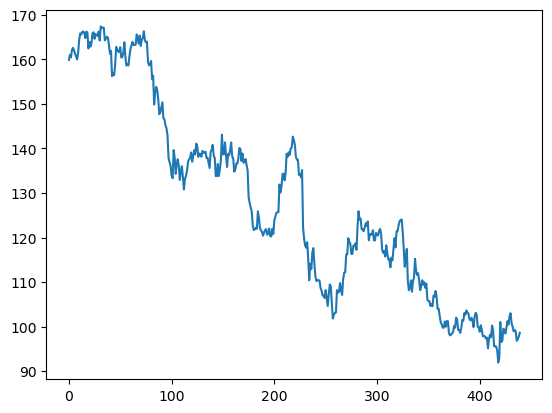

In [19]:
import matplotlib.pyplot as plt

plt.plot(list(dict_train_test['MMM']['Close']))

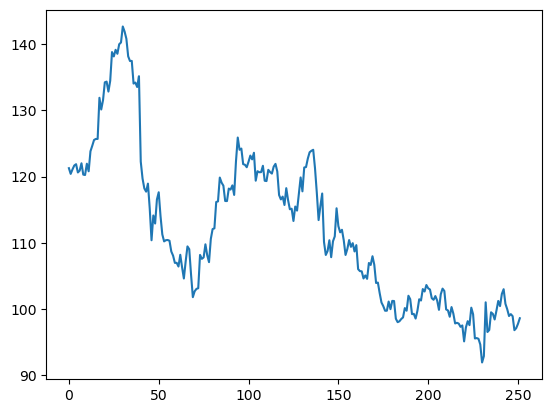

In [20]:
plt.plot(list(grad_obj.chunked_data[12][0]['Close']))

In [21]:
grad_obj.chunk_dates

{1: [(Timestamp('2023-05-30 00:00:00-0400', tz='America/New_York'),
   Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York')),
  (Timestamp('2023-02-28 00:00:00-0500', tz='America/New_York'),
   Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York')),
  (Timestamp('2022-11-30 00:00:00-0500', tz='America/New_York'),
   Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York')),
  (Timestamp('2022-08-30 00:00:00-0400', tz='America/New_York'),
   Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'))],
 3: [(Timestamp('2023-03-30 00:00:00-0400', tz='America/New_York'),
   Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York')),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York')),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York')),
  (Timestamp('2022-06-30 00:00:00-0400', tz='America/New_York'),
   Timestam

In [82]:
def get_data_all_stock(stock_dict, chunk_end_dates):
    grad_dict = {}
    
    for stock in stock_dict.keys():
        grad_object = get_gradients(chunk_end_dates=chunk_end_dates, data=stock_dict[stock])
        grad_dict[stock] = grad_object.get_gradient()
        del grad_object

    return grad_dict

fundamental_data = pickle_loader(r"C:\Users\mszwagrzak\OneDrive - Genomics England Ltd\Documents\stock_analysis2\final_fundamental_dict.pickle")
chunk_end_dates = fundamental_data['MMM'].columns
grad_dict = get_data_all_stock(dict_train_test, chunk_end_dates)

In [84]:
grad_dict.keys()

dict_keys(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'D

In [86]:
grad_dict['AOS'][6]

[(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
  0.24833693109412228),
 (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
  0.35988420120608317),
 (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
  0.05617303218180153),
 (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
  -0.29887060792918185)]

In [88]:
grad_dict['MMM']

{1: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.04109100548755682),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   -0.024712197382614032),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   -0.049208994690998216),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   -0.1220258410531448)],
 3: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   -0.011434601311259925),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   -0.13947837636307123),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   0.09338262001671123),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   -0.14749181556668425)],
 6: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   -0.15222038164937715),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   -0.025212020511116342),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   -0.0542961

### Create Final Dataset

In [90]:
data = grad_dict['AOS']

# Initialize an empty dictionary for the output
restructured_data = {}

# Iterate through each period and the associated list of tuples
for period, values in data.items():
    for timestamp, gradient in values:
        # If the timestamp is not already a key, initialize an empty list for it
        if timestamp not in restructured_data:
            restructured_data[timestamp] = []
        # Append the tuple of period and gradient to the list for this timestamp
        restructured_data[timestamp].append((period, gradient))

# Print or return the restructured dictionary
print(restructured_data)

{Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'): [(1, 0.08733056577491818), (3, 0.07382588498673215), (6, 0.24833693109412228), (12, 0.3034516877725749)], Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'): [(1, 0.05223318885392355), (3, 0.16470620825130192), (6, 0.35988420120608317), (12, 0.09891203355323497)], Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'): [(1, -0.059332175054584976), (3, 0.16943098665730916), (6, 0.05617303218180153), (12, -0.3820053810686794)], Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'): [(1, -0.1671382154828119), (3, -0.11352807899367859), (6, -0.29887060792918185), (12, -0.2108584180782828)]}


In [92]:
class get_final_dataset():

    def __init__(self, grad_dict):
        self.grad_dict = grad_dict

    def get_dataset(self):
        grad_dict = self.grad_dict
        self.re_grad_dict = {k:self.restructure_data(v) for k,v in grad_dict}
        

    def restructure_data(self, data):
        grad_dict = self.grad_dict
        # Initialize an empty dictionary for the output
        restructured_data = {}

        # Iterate through each period and the associated list of tuples
        for period, values in data.items():
            for timestamp, gradient in values:
        # If the timestamp is not already a key, initialize an empty list for it
                if timestamp not in restructured_data:
                    restructured_data[timestamp] = []
                # Append the tuple of period and gradient to the list for this timestamp
                restructured_data[timestamp].append((period, gradient))
        return restructured_data

    def create_dfs(self):
        re_grad_dict = self.re_grad_dict
        timestamps = list(re_grad_dict[list(re_grad_dict.keys())[0]][1].keys())
        index = list(re_grad_dict.keys())
        dict_df_arrays = {timestamp:np.zeros((4, len(index)) for timestamp in timestamps}
        

        for stock, value in re_grad_dict.items():
            for timestamp in timestamps:
                
            
        

{1: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.08733056577491818),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.05223318885392355),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   -0.059332175054584976),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   -0.1671382154828119)],
 3: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.07382588498673215),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.16470620825130192),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   0.16943098665730916),
  (Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'),
   -0.11352807899367859)],
 6: [(Timestamp('2023-06-30 00:00:00-0400', tz='America/New_York'),
   0.24833693109412228),
  (Timestamp('2023-03-31 00:00:00-0400', tz='America/New_York'),
   0.35988420120608317),
  (Timestamp('2022-12-31 00:00:00-0500', tz='America/New_York'),
   0.0561730321818015

In [5]:
import numpy as np
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])